In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta, time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 데이터 세트 로드

url = 'https://raw.githubusercontent.com/gentle-potato/21KDT-Project/master/DataAnalysis%26Visualization/%EA%B8%B0%ED%9B%84%20%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EB%AA%A8%EA%B8%B0%20%EB%B0%9C%EC%83%9D%20%EC%98%88%EB%B3%B4/%EC%9E%91%EC%97%85/4.%20dms_seoul_avg.csv'
tot_df = pd.read_csv(url, encoding='cp949')
tot_df['date'] = pd.to_datetime(tot_df['date'])
tot_df

,date,mosquito,temp,rain_per_day,accum_rain,wind,humidity,sunshine
0,2015-04-06,199,12.214286,5.285714,0,3.371429,68.757143,8.880000
1,2015-04-07,146,11.571429,4.928571,0,3.428571,65.742857,9.891429
2,2015-04-08,90,10.914286,4.571429,0,3.257143,63.542857,9.927143
3,2015-04-09,172,10.171429,0.571429,0,2.871429,59.614286,10.884286
4,2015-04-10,249,10.314286,0.071429,0,2.871429,53.485714,12.777143
...,...,...,...,...,...,...,...,...
1168,2020-10-27,535,11.942857,0.000000,0,2.185714,63.242857,12.734286
1169,2020-10-28,884,11.900000,0.000000,0,2.271429,60.771429,14.241429
1170,2020-10-29,695,11.514286,0.000000,0,2.157143,57.100000,14.635714
1171,2020-10-30,543,11.985714,0.000000,0,1.942857,55.871429,14.294286


In [3]:
tot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173 entries, 0 to 1172
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1173 non-null   datetime64[ns]
 1   mosquito      1173 non-null   int64         
 2   temp          1173 non-null   float64       
 3   rain_per_day  1173 non-null   float64       
 4   accum_rain    1173 non-null   int64         
 5   wind          1173 non-null   float64       
 6   humidity      1173 non-null   float64       
 7   sunshine      1173 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 73.4 KB


In [4]:
mosquitoDF = tot_df.loc[:,'mosquito' :].astype('float')
mosquitoDF.isnull().sum()

mosquito        0
temp            0
rain_per_day    0
accum_rain      0
wind            0
humidity        0
sunshine        0
dtype: int64

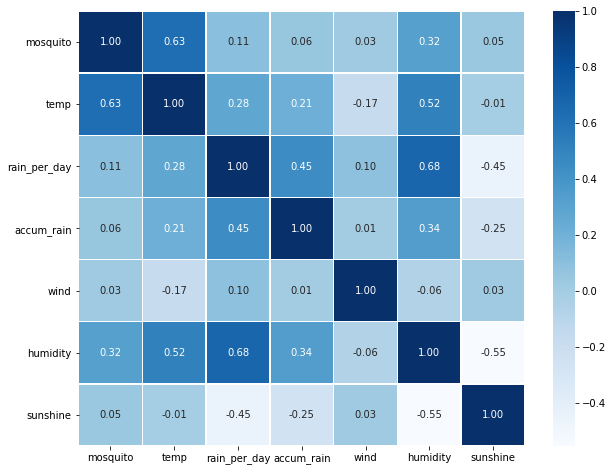

In [5]:
plt.figure(figsize=(10,8))
sns.heatmap(data=mosquitoDF.corr(method='spearman'), annot=True,fmt='.2f', linewidths=.5, cmap='Blues')

In [6]:
mosquitoDF.columns

Index(['mosquito', 'temp', 'rain_per_day', 'accum_rain', 'wind', 'humidity',
       'sunshine'],
      dtype='object')

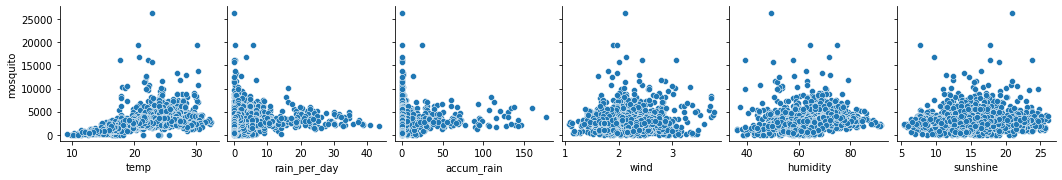

In [7]:
sns.pairplot(mosquitoDF, x_vars=['temp', 'rain_per_day', 'accum_rain', 'wind',
       'humidity', 'sunshine'],y_vars=['mosquito'])

In [8]:
mosquitoDF.head()

,mosquito,temp,rain_per_day,accum_rain,wind,humidity,sunshine
0,199.0,12.214286,5.285714,0.0,3.371429,68.757143,8.880000
1,146.0,11.571429,4.928571,0.0,3.428571,65.742857,9.891429
2,90.0,10.914286,4.571429,0.0,3.257143,63.542857,9.927143
3,172.0,10.171429,0.571429,0.0,2.871429,59.614286,10.884286
4,249.0,10.314286,0.071429,0.0,2.871429,53.485714,12.777143


## Setting Target Variable & Seperating Train-Test Set

In [9]:
X_train = mosquitoDF.iloc[:round(len(mosquitoDF)*0.8),1:-1] 
y_train = mosquitoDF.iloc[:round(len(mosquitoDF)*0.8),0]
X_test = mosquitoDF.iloc[round(len(mosquitoDF)*0.8):,1:-1]
y_test = mosquitoDF.iloc[round(len(mosquitoDF)*0.8):,0]

In [10]:
X_train

,temp,rain_per_day,accum_rain,wind,humidity
0,12.214286,5.285714,0.0,3.371429,68.757143
1,11.571429,4.928571,0.0,3.428571,65.742857
2,10.914286,4.571429,0.0,3.257143,63.542857
3,10.171429,0.571429,0.0,2.871429,59.614286
4,10.314286,0.071429,0.0,2.871429,53.485714
...,...,...,...,...,...
933,23.828571,8.785714,39.0,1.971429,73.342857
934,24.142857,9.185714,5.0,2.557143,74.471429
935,24.285714,9.185714,0.0,2.628571,76.314286
936,24.385714,9.185714,0.0,2.642857,78.842857


In [11]:
y_train

0       199.0
1       146.0
2        90.0
3       172.0
4       249.0
        ...  
933    2914.0
934    3141.0
935    3008.0
936    3361.0
937    3310.0
Name: mosquito, Length: 938, dtype: float64

## Training LGBM & GBR & RFR

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [14]:
def models(name = '', train_x = '', train_y = '', test_x = '', test_y = '') :

  # 1. LGBM(Light Gradient Boosting Machine)
  lgb_reg = make_pipeline(StandardScaler(), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=7,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10, n_jobs=-1, num_leaves=31, objective=None,
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0))
  
  lgb_reg.fit(train_x, train_y)

  # 2. GBR(Gradient Boosting Regressor)
  gb_reg = make_pipeline(StandardScaler(), GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None,random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False))
  
  gb_reg.fit(train_x, train_y)

  # 3. RFR(Random Forest Regressor)
  rf_reg = make_pipeline(StandardScaler(), RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False))
  
  rf_reg.fit(train_x, train_y)


  print(lgb_reg)
  y_preds_lgb = lgb_reg.predict(test_x)
  print('LGB MAE : {:.3f}'.format(mean_absolute_error(y_test, y_preds_lgb)))
  print('LGB MSE : {:.3f}'.format(mean_squared_error(y_test, y_preds_lgb)))
  print('LGB RMSE : {:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_preds_lgb))))
  print('LGB R2 : {:.3f}'.format(r2_score(y_test, y_preds_lgb)))
  print('------------------------------------------------------------------------------------')
  
  print(lgb_reg)
  y_preds_gb = gb_reg.predict(X_test)
  print('GBR MAE : {:.3f}'.format(mean_absolute_error(y_test, y_preds_gb)))
  print('GBR MSE : {:.3f}'.format(mean_squared_error(y_test, y_preds_gb)))
  print('GBR RMSE : {:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_preds_gb))))
  print('GBR R2 : {:.3f}'.format(r2_score(y_test, y_preds_gb)))
  print('------------------------------------------------------------------------------------')
  
  print(lgb_reg)
  y_preds_rf = gb_reg.predict(X_test)
  print('RFR MAE : {:.3f}'.format(mean_absolute_error(y_test, y_preds_rf)))
  print('RFR MSE : {:.3f}'.format(mean_squared_error(y_test, y_preds_rf)))
  print('RFR RMSE : {:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_preds_rf))))
  print('RFR R2 : {:.3f}'.format(r2_score(y_test, y_preds_rf)))
  print('------------------------------------------------------------------------------------')
  
  df = pd.DataFrame({'result' : test_y, 'LGBM' : y_preds_lgb , 'GBR' : y_preds_gb, 'RFR' : y_preds_rf})
  
  return df

In [15]:
df = models('test', X_train, y_train, X_test, y_test)
df.head()

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lgbmregressor',
                 LGBMRegressor(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=1.0, importance_type='split',
                               learning_rate=0.1, max_depth=7,
                               min_child_samples=20, min_child_weight=0.001,
                               min_split_gain=0.0, n_estimators=10, n_jobs=-1,
                               num_leaves=31, objective=None, random_state=0,
                               reg_alpha=0.0, reg_lambda=0.0, silent=True,
                               subsample=1.0, subsample_for_bin=200000,
                               subsample_freq=0))],
         verbose=False)
LGB MAE : 1360.966
LGB MSE : 2405971.956
LGB RMSE : 1551.120
LGB R2 : -1.358
------------------------------------------------------------------------------------
P

,result,LGBM,GBR,RFR
938,2797.0,4061.008028,4544.821344,4544.821344
939,2580.0,4661.379446,4718.717164,4718.717164
940,2518.0,4635.950291,4544.821344,4544.821344
941,3337.0,4270.955045,4544.821344,4544.821344
942,2530.0,4270.955045,4544.821344,4544.821344


In [16]:
df['time'] = tot_df['date']
df = df.set_index('time', drop = True)
df.head()

,result,LGBM,GBR,RFR
time,,,,
2019-09-11,2797.0,4061.008028,4544.821344,4544.821344
2019-09-12,2580.0,4661.379446,4718.717164,4718.717164
2019-09-13,2518.0,4635.950291,4544.821344,4544.821344
2019-09-14,3337.0,4270.955045,4544.821344,4544.821344
2019-09-15,2530.0,4270.955045,4544.821344,4544.821344


In [17]:
df.tail()

,result,LGBM,GBR,RFR
time,,,,
2020-10-27,535.0,1434.011314,1865.903773,1865.903773
2020-10-28,884.0,1434.011314,1865.903773,1865.903773
2020-10-29,695.0,1434.011314,1865.903773,1865.903773
2020-10-30,543.0,1434.011314,1865.903773,1865.903773
2020-10-31,454.0,1628.309554,1865.903773,1865.903773


In [18]:
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100

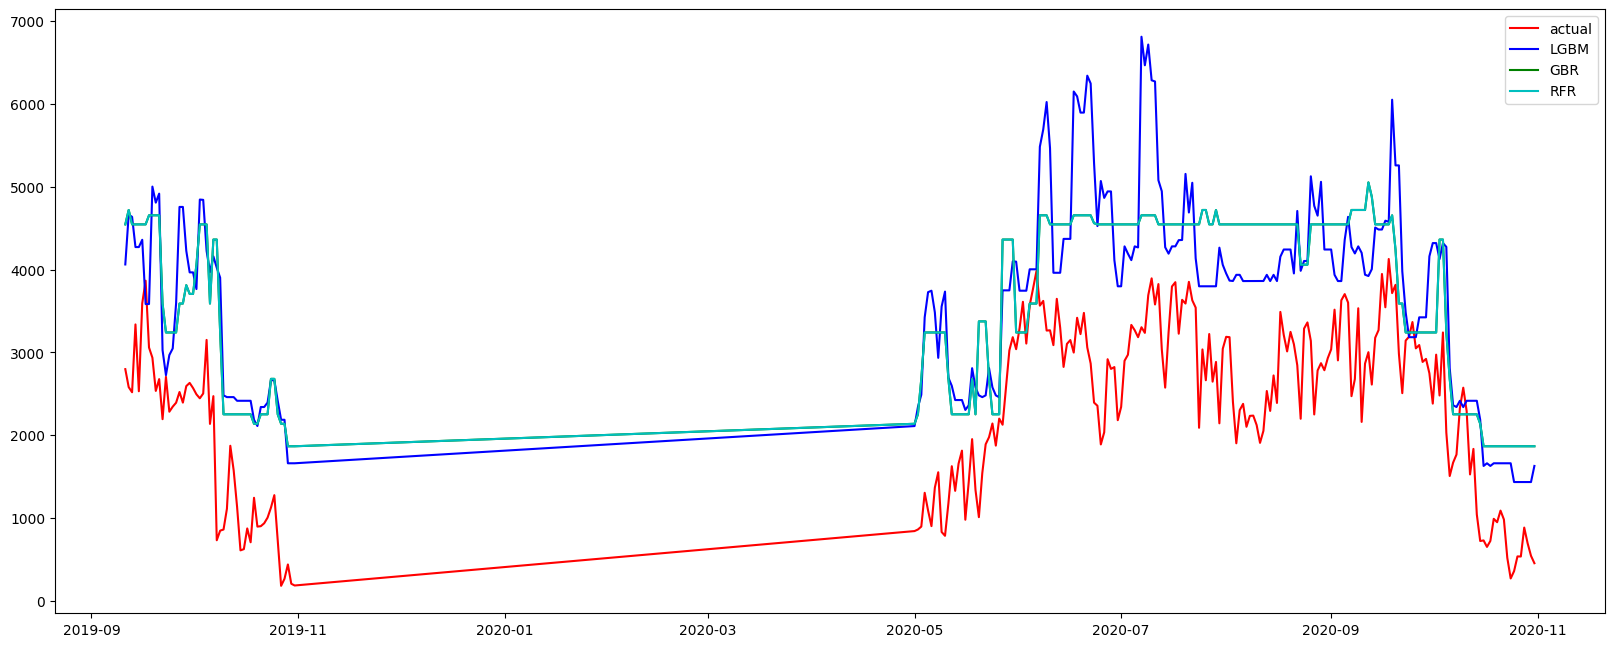

In [19]:
plt.plot(df.result,'r', label = 'actual')
plt.plot(df.LGBM, 'b', label = 'LGBM')
plt.plot(df.GBR, 'g', label = 'GBR')
plt.plot(df.RFR, 'c', label = 'RFR')
plt.legend()
plt.show()